In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_error
from math import sqrt
import lightgbm as lgb
import time

In [2]:
train = pd.read_csv(os.path.join('data', 'train.csv'))
test = pd.read_csv(os.path.join('data', 'test.csv'))
hist = pd.read_csv(os.path.join('data', 'historical_transactions.csv'))
merch = pd.read_csv(os.path.join('data', 'merchants.csv'))
new_merch = pd.read_csv(os.path.join('data', 'new_merchant_transactions.csv'))
mcf = pd.read_csv("monthly_card_features.csv")
new_train = pd.read_csv("new_train.csv")
new_test = pd.read_csv("new_test.csv")

In [3]:
hist["purchase_raw"] = hist["purchase_amount"] / 0.00150265118 + 497.06
new_merch["purchase_raw"] = new_merch["purchase_amount"] / 0.00150265118 + 497.06
train['target_raw'] = 2**train['target']

In [151]:
#mcf.groupby(["card_id"]).mean().merge(train, on = "card_id").corr()

In [4]:
temp_mcf = mcf.groupby(["card_id"]).mean()

In [5]:
train = train.merge(temp_mcf, on = "card_id")

In [6]:
test = test.merge(temp_mcf , on = "card_id")

In [7]:
tr = new_train.merge(temp_mcf, on = "card_id")

In [8]:
te = new_test.merge(temp_mcf, on = "card_id")

In [9]:
training = tr.drop([tr.columns[0],"first_active_month", "card_id", "target"], axis = 1)

In [10]:
testing = te.drop([te.columns[0],"first_active_month", "card_id"], axis = 1)

In [13]:
target = tr["target"]

In [14]:
tr_no = tr[tr['target'] > -20]
training_no = tr_no.drop([tr_no.columns[0],"first_active_month", "card_id", "target"], axis = 1)
target_no = tr_no['target']

In [15]:
training_no.head()
training_no.describe()

,feature_1,feature_2,feature_3,tof,recency,frequency,log_freq,amt,avg_amt,charge_per_day,...,merch_cat_2_2,merch_cat_2_3,merch_cat_2_4,merch_cat_2_5,month_lag,amt_total,amt_new,NDR,n_new_merchants,n_total_merchants
count,199710.000000,199710.000000,199710.000000,199710.000000,199710.000000,199710.000000,199710.000000,1.997100e+05,199710.000000,199710.000000,...,199710.000000,199710.000000,199710.000000,199710.000000,199710.000000,1.997100e+05,1.997100e+05,199710.000000,199710.000000,199710.000000
mean,3.103996,1.745000,0.565285,350.416794,56.194532,95.449041,4.101275,1.109401e+01,1.519812,0.280781,...,3.351179,12.939708,8.564183,12.210435,-3.141029,7.625674e+03,6.407671e+03,0.681026,4.614413,24.170710
std,1.185855,0.750679,0.495721,119.321843,75.689871,107.139007,0.964509,1.352179e+04,708.594765,0.285439,...,24.032367,44.394485,40.231007,45.405123,2.034249,1.793450e+06,1.792587e+06,0.191681,3.294622,21.029100
min,1.000000,1.000000,0.000000,120.000000,0.000000,2.000000,0.693147,-2.089630e+03,-0.745371,0.004255,...,0.000000,0.000000,0.000000,0.000000,-12.000000,3.445000e+00,7.142857e-02,0.071429,1.000000,1.000000
25%,2.000000,1.000000,0.000000,241.000000,7.000000,31.000000,3.433987,-7.023937e+01,-0.677769,0.096939,...,0.000000,0.000000,0.000000,0.000000,-5.000000,3.110148e+02,1.969507e+02,0.551268,2.400000,10.000000
50%,3.000000,2.000000,1.000000,374.000000,26.000000,60.000000,4.094345,-3.367446e+01,-0.620319,0.190476,...,0.000000,0.000000,0.000000,0.000000,-3.000000,6.107410e+02,3.922689e+02,0.693371,3.700000,18.000000
75%,4.000000,2.000000,1.000000,471.000000,69.000000,118.000000,4.770685,-1.469988e+01,-0.503041,0.360000,...,0.000000,2.000000,0.000000,1.000000,-1.500000,1.287505e+03,8.409493e+02,0.826079,5.750000,31.285714
max,5.000000,3.000000,1.000000,484.000000,450.000000,2915.000000,7.977625,6.010591e+06,316346.913213,6.085595,...,2554.000000,1222.000000,1389.000000,1226.000000,0.500000,8.000001e+08,8.000001e+08,1.000000,47.500000,260.428571


## Cross Validation

In [16]:
training.shape

(201917, 27)

In [17]:
training = np.array(training)
testing = np.array(testing)

In [17]:
#params = {"n_estimators":[25,30],"learning_rate":[.01, .1], "max_depth":[5,8]}

In [18]:
start_time = time.time()

params = {"n_estimators":[100, 200, 300],"learning_rate":[.01, .1, 1], "max_depth":[5, 8, 10]}
gsearch = GridSearchCV(estimator = GradientBoostingRegressor(n_estimators=100,learning_rate=0.01,
                                                               max_depth=5,random_state=0), 
param_grid = params, scoring='r2',n_jobs=4,iid=False, cv=5)
out = gsearch.fit(training,target)

end_time = time.time()

In [19]:
out


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=0,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'n_estimators': [100], 'learning_rate': [0.01, 0.1, 1], 'max_depth': [5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [20]:
out.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=0,
             subsample=1.0, verbose=0, warm_start=False)

In [21]:
out.grid_scores_, out.best_params_, out.best_score_

C:\Users\JD Cook\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.04970, std: 0.00277, params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100},
  mean: 0.06695, std: 0.00608, params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100},
  mean: -0.24483, std: 0.03769, params: {'learning_rate': 1, 'max_depth': 5, 'n_estimators': 100}],
 {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100},
 0.06694514907409546)

In [25]:
(end_time - start_time) / 60

39.177983295917514

C:\Users\JD Cook\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\JD Cook\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\JD Cook\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\JD Cook\Anaconda3\lib\site-packages\skle

{'mean_fit_time': array([619.1544836 , 558.02277956, 461.26403618]),
 'std_fit_time': array([ 9.64035249,  3.94872955, 61.65765596]),
 'mean_score_time': array([0.33849893, 0.24714751, 0.22559118]),
 'std_score_time': array([0.02198159, 0.0142029 , 0.08049183]),
 'param_learning_rate': masked_array(data=[0.01, 0.1, 1],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[5, 5, 5],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[100, 100, 100],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100},
  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100},
  {'learning_rate': 1, 'max_depth': 5, 'n_estimators': 100}],
 'split0_test_score': array([ 0.05149821,  0.06766288, -0.2568273 ]),
 'split1_test_score':

In [22]:
# kf = KFold(n_splits=2)
# kf.get_n_splits(training)

In [23]:
# rmse = []

# parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
# svc = svm.SVC(gamma="scale")
# clf = GridSearchCV(svc, parameters, cv=5)
# clf.fit(iris.data, iris.target)

# for train_index, test_index in kf.split(training_no):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = training[train_index], training[test_index]
#     y_train, y_test = target[train_index], target[test_index]
    
#     for i in range(10):
#     est = GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, 
#                                 max_depth=10, random_state=0, loss='ls').fit(X_train, y_train)
    
#     preds = est.predict(X_test)
#     rms = sqrt(mean_squared_error(y_test, preds))
#     print(rms)
#     rmse.append(rms)
    

In [26]:
est = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, 
                                max_depth=5, random_state=0, loss='ls').fit(training, target)

In [27]:
preds = est.predict(testing)

In [32]:
est.feature_importances_

array([0.00843707, 0.00316245, 0.00496303, 0.03387758, 0.18580802,
       0.01496189, 0.01645434, 0.04311035, 0.03477223, 0.01994632,
       0.02570546, 0.04590409, 0.02197238, 0.03056773, 0.07389079,
       0.10730452, 0.02478021, 0.01612672, 0.01386501, 0.02028455,
       0.01016212, 0.07809694, 0.02530678, 0.02973599, 0.06102051,
       0.02348053, 0.0263024 ])

In [51]:
nam = list(tr.columns[3:])

In [54]:
del nam[3:4]

In [57]:
importance = pd.DataFrame(
{"Feature" : nam,
"Importance" : est.feature_importances_}
)

In [63]:
importance.sort_values("Importance", ascending=False).to_clipboard(excel = True)

201917

In [28]:
submit = pd.DataFrame(
{"card_id" : te["card_id"],
"target" : preds}
)

In [29]:
submit.to_csv("submission4.csv", index = False)
submit.head()

,card_id,target
0,C_ID_0ab67a22ab,-1.330444
1,C_ID_130fd0cbdd,-0.409459
2,C_ID_b709037bc5,-0.342483
3,C_ID_d27d835a9f,-0.187621
4,C_ID_2b5e3df5c2,-0.341806


In [30]:
submit.shape

(123623, 2)

,Unnamed: 0,first_active_month,card_id,feature_1,feature_2,feature_3,target,tof,recency,frequency,...,merch_cat_2_2,merch_cat_2_3,merch_cat_2_4,merch_cat_2_5,month_lag,amt_total,amt_new,NDR,n_new_merchants,n_total_merchants
0,0,2017-06,C_ID_92a2005557,5,2,1,-0.820283,307,1,283,...,0,0,0,3,-3.0,1945.770909,1250.068182,0.628712,10.727273,64.636364
1,1,2017-01,C_ID_3d0044924f,4,1,0,0.392913,479,31,356,...,0,0,0,0,-5.0,2286.496667,1343.459333,0.579422,9.866667,87.600000
2,2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056,474,2,44,...,0,0,0,40,-6.0,153.381538,63.333077,0.278886,2.333333,10.538462
3,3,2017-09,C_ID_186d6a6901,4,3,0,0.142495,216,12,84,...,0,0,59,0,-1.5,714.946250,600.791250,0.863584,7.125000,39.000000
4,4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749,169,2,169,...,0,7,132,1,-0.5,6390.208333,5883.170000,0.923486,17.166667,59.166667


## LightGBM

In [266]:
outs = tr[tr.outlier]
ins = tr[-tr.outlier]

In [286]:
tra = tr
tes = te
tra['outlier'] = tra['target'] < -20

In [287]:
target = tra['outlier']
del tra['outlier']
del tra['target']

In [288]:
features = [c for c in tra.columns if c not in ['Unnamed: 0', 'card_id', 'first_active_month']]
categorical_feats = [c for c in features if 'feature_' in c]

In [289]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'binary',
         'max_depth': 6,
         'learning_rate': 0.01,
         "boosting": "rf",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'binary_logloss',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "random_state": 2333}

In [291]:
%%time
folds = KFold(n_splits=2, shuffle=True, random_state=15)
oof = np.zeros(len(tra))
predictions = np.zeros(len(tes))
feature_importance_df = pd.DataFrame()

start = time.time()


for fold_, (trn_idx, val_idx) in enumerate(folds.split(tra.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(tra.iloc[trn_idx][features], label=target.iloc[trn_idx], categorical_feature=categorical_feats)
    val_data = lgb.Dataset(tra.iloc[val_idx][features], label=target.iloc[val_idx], categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(tra.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(tes[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(log_loss(target, oof)))

fold n°0


C:\Users\JD Cook\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\JD Cook\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.0467675	valid_1's binary_logloss: 0.0471705
[200]	training's binary_logloss: 0.0467241	valid_1's binary_logloss: 0.0471203
[300]	training's binary_logloss: 0.0466577	valid_1's binary_logloss: 0.0470768
[400]	training's binary_logloss: 0.0466437	valid_1's binary_logloss: 0.0470687
[500]	training's binary_logloss: 0.0466495	valid_1's binary_logloss: 0.0470837
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.0466383	valid_1's binary_logloss: 0.0470622
fold n°1
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.0445756	valid_1's binary_logloss: 0.0487765
[200]	training's binary_logloss: 0.0445694	valid_1's binary_logloss: 0.0487747
[300]	training's binary_logloss: 0.0445583	valid_1's binary_logloss: 0.0487578
Early stopping, best iteration is:
[149]	training's binary_logloss: 0.0445538	valid_1's binary_logloss: 0.0487609
CV sc

In [302]:
trn_data = lgb.Dataset(tr[features], label=target, categorical_feature=categorical_feats)

In [303]:
clf = lgb.train(param, trn_data, 100)

C:\Users\JD Cook\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [308]:
tes = tes.drop(["Unnamed: 0", "first_active_month", "card_id"], axis = 1)

In [324]:
y_pred=clf.predict(tes)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001CA83E3B978>]],
      dtype=object)

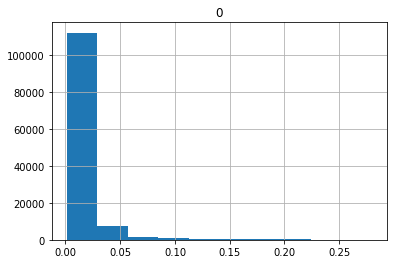

In [326]:
pd.DataFrame(y_pred).hist()

In [322]:
for i in range(0,len(y_pred)):
    if y_pred[i]>=.2:       # setting threshold to .5
        y_pred[i]=1
    else:  
        y_pred[i]=0

In [323]:
sum(y_pred == 1)

0

In [304]:
#Prediction
y_pred=clf.predict(tes)
#convert into binary values
for i in range(0,99):
    if y_pred[i]>=.5:       # setting threshold to .5
        y_pred[i]=1
    else:  
       y_pred[i]=0

ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in fields first_active_month, card_id